In [1]:
!pip install pandas numpy openpyxl requests lightgbm


In [2]:
!pip install scikit-learn


In [3]:
import pandas as pd
import numpy as np
import pickle
import requests
from io import BytesIO

In [4]:
import pandas as pd
import numpy as np
import pickle
import requests
from io import BytesIO
from scipy.stats import boxcox

# ===== 1. ЗАГРУЖАЕМ TEST.XLSX =====
GITHUB_TEST_XLSX_URL = "https://github.com/samoletpanfilov/reinforcement_task/raw/master/data/test.xlsx"

response = requests.get(GITHUB_TEST_XLSX_URL)
test_data = pd.read_excel(BytesIO(response.content))

# ===== 2. ПРЕДОБРАБАТЫВАЕМ ДАННЫЕ =====
test_data["dt"] = pd.to_datetime(test_data["dt"], errors="coerce")
test_data = test_data.sort_values(by="dt")  # Сортировка по дате

# 🔹 Генерация временных фичей
test_data["year"] = test_data["dt"].dt.year
test_data["month"] = test_data["dt"].dt.month
test_data["quarter"] = test_data["dt"].dt.quarter
test_data["day_of_month"] = test_data["dt"].dt.day
test_data["day_of_week"] = test_data["dt"].dt.weekday

if "Цена на арматуру" in test_data.columns:
    test_data["rolling_std"] = test_data["Цена на арматуру"].rolling(5, min_periods=1).std()
    test_data["normalized_price"] = (test_data["Цена на арматуру"] - test_data["Цена на арматуру"].min()) / (test_data["Цена на арматуру"].max() - test_data["Цена на арматуру"].min())
    test_data["log_normalized_price"] = np.log1p(test_data["normalized_price"])
    test_data["stationary_price"] = test_data["Цена на арматуру"].diff().fillna(0)
    test_data["boxcox_price"], _ = boxcox(test_data["Цена на арматуру"].clip(lower=0.01))
    test_data["diff_boxcox_price"] = test_data["boxcox_price"].diff().fillna(0)

    # 🔹 Лаги (без заполнения)
    max_lag = 12
    for lag in range(1, max_lag + 1):
        test_data[f"lag_{lag}"] = test_data["Цена на арматуру"].shift(lag)

    # 🔹 Скользящие средние
    test_data["rolling_mean_3"] = test_data["Цена на арматуру"].rolling(3, min_periods=1).mean()
    test_data["rolling_mean_6"] = test_data["Цена на арматуру"].rolling(6, min_periods=1).mean()
    test_data["rolling_mean_12"] = test_data["Цена на арматуру"].rolling(12, min_periods=1).mean()

    # 🔹 Экспоненциальные средние
    test_data["ewm_6"] = test_data["Цена на арматуру"].ewm(span=6, adjust=False).mean()
    test_data["ewm_12"] = test_data["Цена на арматуру"].ewm(span=12, adjust=False).mean()

    # 🔹 Разности
    test_data["diff_1"] = test_data["Цена на арматуру"].diff(1)
    test_data["diff_3"] = test_data["Цена на арматуру"].diff(3)

# Удаляем ненужные колонки
features = test_data.drop(columns=["dt"], errors="ignore")

# ===== 3. ЗАГРУЖАЕМ МОДЕЛЬ =====
with open("lightgbm_model.pkl", "rb") as model_file:
    model = pickle.load(model_file)

# ===== 4. ПРОГНОЗИРУЕМ =====
# Проверяем, какие признаки есть в модели
model_features = set(model.feature_name())  # Booster
common_features = list(model_features & set(features.columns))
features = features[common_features]

# Предсказываем, округляя до целого числа N (недель)
test_data.loc[features.index, "N"] = np.round(model.predict(features)).astype(int)

# ===== 5. СОХРАНЯЕМ РЕЗУЛЬТАТ =====
output_path = "test.xlsx"
test_data.to_excel(output_path, index=False)

print(f"Файл {output_path} сохранён с прогнозом N.")


Файл test.xlsx сохранён с прогнозом N.


📊 Оценка точности модели:
🔹 MAE  (Средняя абсолютная ошибка)  = 13587.71
🔹 RMSE (Среднеквадратичная ошибка) = 14304.94
🔹 MAPE (Средняя процентная ошибка) = 31.46%


e:\timoha\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


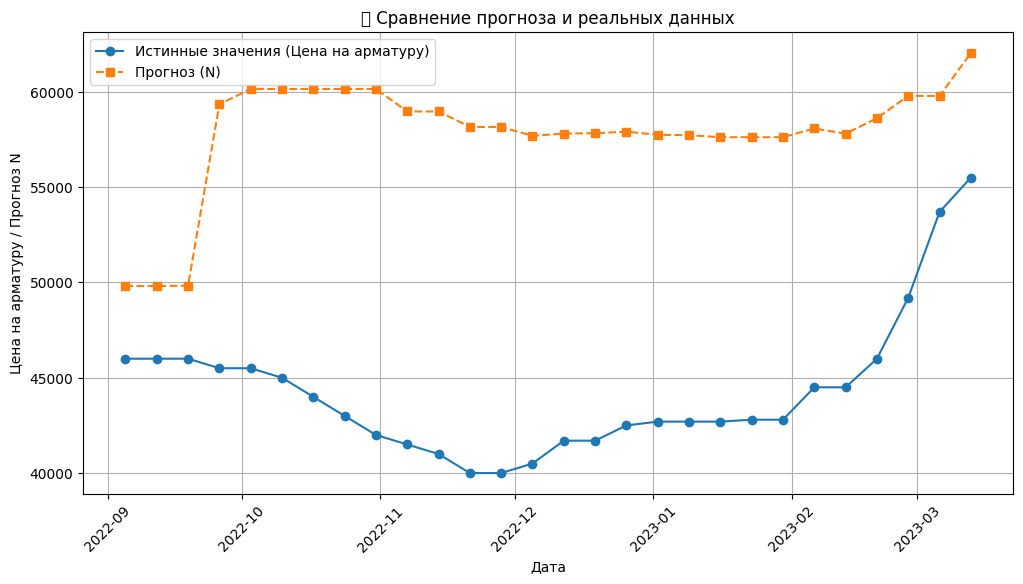

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 1️⃣ Загружаем исходные данные с GitHub
GITHUB_TEST_XLSX_URL = "https://github.com/samoletpanfilov/reinforcement_task/raw/master/data/test.xlsx"
original_data = pd.read_excel(GITHUB_TEST_XLSX_URL)

# 2️⃣ Загружаем предсказанные данные
predicted_data = pd.read_excel("test.xlsx")

# 3️⃣ Проверяем, есть ли нужные колонки
if "Цена на арматуру" in original_data.columns and "N" in predicted_data.columns:
    # 4️⃣ Объединяем таблицы по дате
    merged_data = original_data[["dt", "Цена на арматуру"]].merge(
        predicted_data[["dt", "N"]], on="dt", how="inner"
    )

    y_true = merged_data["Цена на арматуру"]
    y_pred = merged_data["N"]

    # 🔹 Метрики точности
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))  # Исправлено
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    print(f"📊 Оценка точности модели:")
    print(f"🔹 MAE  (Средняя абсолютная ошибка)  = {mae:.2f}")
    print(f"🔹 RMSE (Среднеквадратичная ошибка) = {rmse:.2f}")
    print(f"🔹 MAPE (Средняя процентная ошибка) = {mape:.2f}%")

    # 🔹 Визуализация
    plt.figure(figsize=(12, 6))
    plt.plot(merged_data["dt"], y_true, label="Истинные значения (Цена на арматуру)", marker="o")
    plt.plot(merged_data["dt"], y_pred, label="Прогноз (N)", marker="s", linestyle="dashed")

    plt.xlabel("Дата")
    plt.ylabel("Цена на арматуру / Прогноз N")
    plt.title("📈 Сравнение прогноза и реальных данных")
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.show()

else:
    print("⚠ Нет необходимых колонок для анализа.")


In [6]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns
# from scipy import stats
# from sklearn.preprocessing import QuantileTransformer

# # Генерация случайных данных (замени на свои)
# np.random.seed(42)
# price = np.random.normal(loc=45000, scale=3000, size=100)  # Средняя цена 45000, стандартное отклонение 3000

# # Удаление выбросов по IQR
# Q1 = np.percentile(price, 25)
# Q3 = np.percentile(price, 75)
# IQR = Q3 - Q1
# lower_bound = Q1 - 1.5 * IQR
# upper_bound = Q3 + 1.5 * IQR
# price_cleaned = price[(price >= lower_bound) & (price <= upper_bound)]

# # Преобразование Yeo-Johnson
# price_yj, lambda_yj = stats.yeojohnson(price_cleaned)

# # Квантильное преобразование
# qt = QuantileTransformer(output_distribution='normal', n_quantiles=min(100, len(price_cleaned)))
# price_qt = qt.fit_transform(price_cleaned.reshape(-1, 1)).flatten()

# # Визуализация данных
# fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# # Исходное распределение
# sns.histplot(price, bins=30, kde=True, ax=axes[0, 0])
# axes[0, 0].set_title("Исходное распределение")
# axes[0, 0].set_xlabel("Цена на арматуру")

# # Без выбросов (IQR)
# sns.histplot(price_cleaned, bins=30, kde=True, ax=axes[0, 1])
# axes[0, 1].set_title("Без выбросов (IQR)")
# axes[0, 1].set_xlabel("Цена на арматуру")

# # Yeo-Johnson
# if len(price_yj) > 0:
#     sns.histplot(price_yj, bins=10, kde=True, ax=axes[1, 0])
#     axes[1, 0].set_title(f"Yeo-Johnson (λ={lambda_yj:.2f})")
#     axes[1, 0].set_xlabel("Трансформированная цена")
# else:
#     axes[1, 0].text(0.5, 0.5, "Нет данных", fontsize=12, ha="center")
#     axes[1, 0].set_title("Yeo-Johnson (пустой)")

# # Квантильное преобразование
# if len(price_qt) > 0:
#     sns.histplot(price_qt, bins=10, kde=True, ax=axes[1, 1])
#     axes[1, 1].set_title("Квантильное преобразование")
#     axes[1, 1].set_xlabel("Трансформированная цена")
# else:
#     axes[1, 1].text(0.5, 0.5, "Нет данных", fontsize=12, ha="center")
#     axes[1, 1].set_title("Квантильное преобразование (пустой)")

# plt.tight_layout()
# plt.show()



In [7]:
# from scipy.stats import skew, kurtosis

# # Функция для расчёта показателей
# def calc_stats(data, name):
#     print(f"{name}:")
#     print(f"  Асимметрия (skewness): {skew(data):.4f}")
#     print(f"  Эксцесс (kurtosis): {kurtosis(data):.4f}")
#     print("-" * 40)

# # Расчёт для всех вариантов
# calc_stats(price, "Исходное распределение")
# calc_stats(price_cleaned, "Без выбросов (IQR)")
# calc_stats(price_yj, "Yeo-Johnson")
# calc_stats(price_qt, "Квантильное преобразование")
